In [82]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet
from upsetplot import from_contents

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/new_plots_forYuXuan/"

In [83]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [84]:
# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]
csv_files = [f for f in csv_files if f.startswith("AGEMales_")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    #key = '_'.join(filename.split("_")[0:4])
    key = filename
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

In [85]:
mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)

In [86]:
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [87]:
di = {'AGEMales_Mid_Old_Rapa Early_20240606.csv':"MidOld_RapaEarly",
       'AGEMales_YoungRapa Adult_OldRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_OldRapaEarly",
       'AGEMales_MidRapa Adult_OldRapa Late_Rapa Early_20240606.csv':"MidRapaAdult_OldRapaLate",
       'AGEMales_YoungRapa Adult_MidRapa Early_Rapa Early_20240606.csv':"YoungRapaAdult_MidRapaEarly",
       'AGEMales_Young_Mid_Control_20240606.csv':"YoungMid_Control",
       'AGEMales_Mid_Old_Control_20240606.csv':"MidOld_Control",
       'AGEMales_Young_Mid_Rapa Adult_20240606.csv':"YoungMid_RapaAdult",
       'AGEMales_Young_Old_Rapa Adult_20240606.csv':"YoungOld_RapaAdult",
       'AGEMales_Mid_Old_Rapa Adult_20240606.csv':"MidOld_RapaAdult",
       'AGEMales_MidControl_OldRapa Late_Rapa Early_20240606.csv':"MidControl_OldRapaLate",
       'AGEMales_Young_Old_Control_20240606.csv':"YoungOld_Control"}
mer = mer.replace({"fullname": di})

In [88]:
merX = mer[mer["log2FoldChange"] > 0]

In [89]:
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

YoungRapaAdult_MidRapaEarly = merX[merX["fullname"] == "YoungRapaAdult_MidRapaEarly"]["OTU"]
MidOld_RapaEarly = merX[merX["fullname"] == "MidOld_RapaEarly"]["OTU"]
MidRapaAdult_OldRapaLate = merX[merX["fullname"] == "MidRapaAdult_OldRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85818/1526806725.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


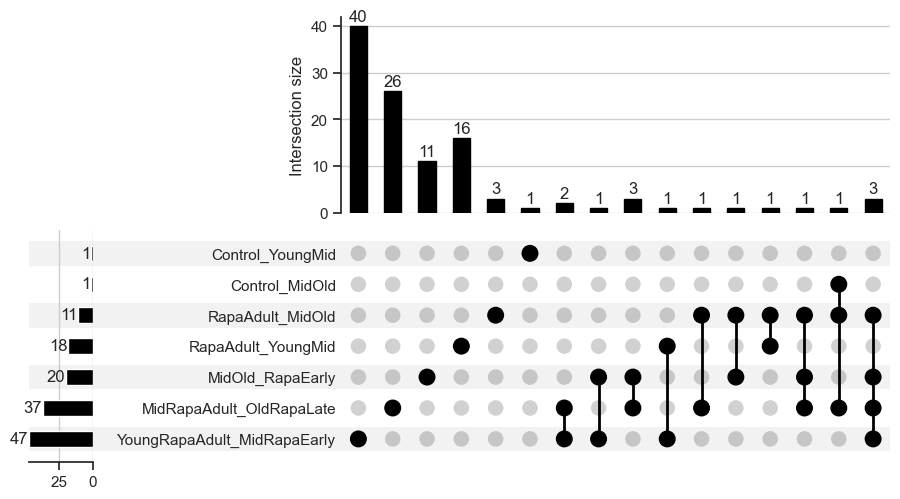

In [90]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid,
    "YoungRapaAdult_MidRapaEarly":YoungRapaAdult_MidRapaEarly, "MidOld_RapaEarly":MidOld_RapaEarly,
    "MidRapaAdult_OldRapaLate":MidRapaAdult_OldRapaLate}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/MALE_Memory_upregulated_uppset.pdf")

In [93]:
merX = mer[mer["log2FoldChange"] < 0]

In [94]:
RapaAdult_MidOld = merX[merX["fullname"] == "MidOld_RapaAdult"]["OTU"]
RapaAdult_YoungMid = merX[merX["fullname"] == "YoungMid_RapaAdult"]["OTU"]

Control_MidOld = merX[merX["fullname"] == "MidOld_Control"]["OTU"]
Control_YoungMid = merX[merX["fullname"] == "YoungMid_Control"]["OTU"]

YoungRapaAdult_MidRapaEarly = merX[merX["fullname"] == "YoungRapaAdult_MidRapaEarly"]["OTU"]
MidOld_RapaEarly = merX[merX["fullname"] == "MidOld_RapaEarly"]["OTU"]
MidRapaAdult_OldRapaLate = merX[merX["fullname"] == "MidRapaAdult_OldRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85818/4172123685.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


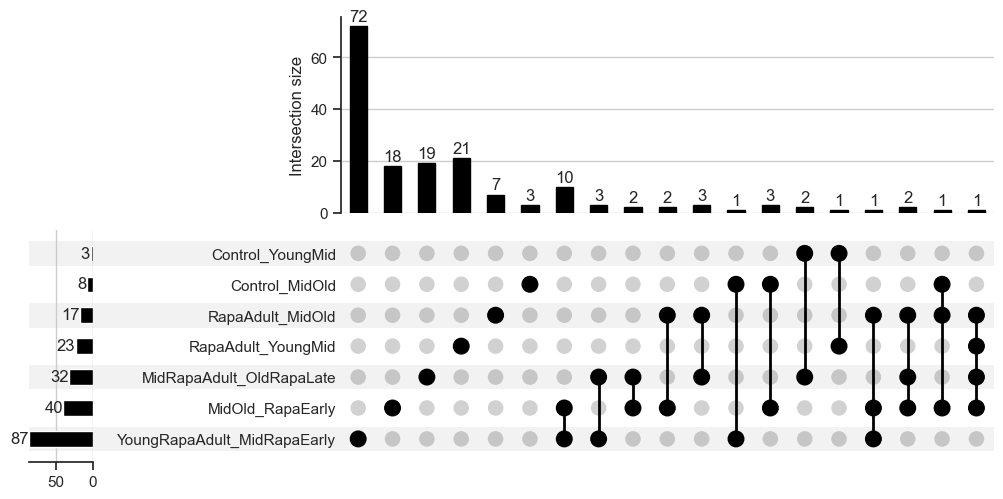

In [95]:
changes = from_contents(
    {"RapaAdult_YoungMid": RapaAdult_YoungMid, "RapaAdult_MidOld": RapaAdult_MidOld,
    "Control_MidOld":Control_MidOld, "Control_YoungMid":Control_YoungMid,
    "YoungRapaAdult_MidRapaEarly":YoungRapaAdult_MidRapaEarly, "MidOld_RapaEarly":MidOld_RapaEarly,
    "MidRapaAdult_OldRapaLate":MidRapaAdult_OldRapaLate}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/MALE_Memory_downregulated_uppset.pdf")

In [96]:
print(pd.Series(list(set(RapaAdult_YoungMid) & set(YoungRapaAdult_MidRapaEarly))))
print(pd.Series(list(set(RapaAdult_MidOld) & set(MidOld_RapaEarly))))
print(pd.Series(list(set(RapaAdult_MidOld) & set(MidRapaAdult_OldRapaLate))))
print(pd.Series(list(set(MidOld_RapaEarly) & set(MidRapaAdult_OldRapaLate))))

Series([], dtype: float64)
0      ASV_5
1     ASV_34
2      ASV_4
3    ASV_223
4     ASV_35
5     ASV_93
6    ASV_148
dtype: object
0     ASV_5
1     ASV_4
2    ASV_28
3    ASV_26
4    ASV_88
5    ASV_93
dtype: object
0     ASV_5
1     ASV_4
2    ASV_58
3    ASV_93
4    ASV_49
dtype: object


/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85818/3177320845.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(pd.Series(list(set(RapaAdult_YoungMid) & set(YoungRapaAdult_MidRapaEarly))))


In [97]:
upreg = mer[mer["log2FoldChange"] > 0]
upreg["reg"] = "up_in_older"
downreg = mer[mer["log2FoldChange"] < 0]
downreg["reg"] = "down_in_older"

mer = pd.concat([upreg, downreg])

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85818/31300130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upreg["reg"] = "up_in_older"
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_85818/31300130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downreg["reg"] = "down_in_older"


In [98]:
## Do chronics
memory = mer[mer["fullname"].isin(["YoungMid_RapaAdult",
                                  'YoungMid_Control',
                                   'MidOld_Control',
                                  'MidOld_RapaAdult',
                                  "YoungRapaAdult_MidRapaEarly",
                                  "MidOld_RapaEarly", "MidRapaAdult_OldRapaLate"])]

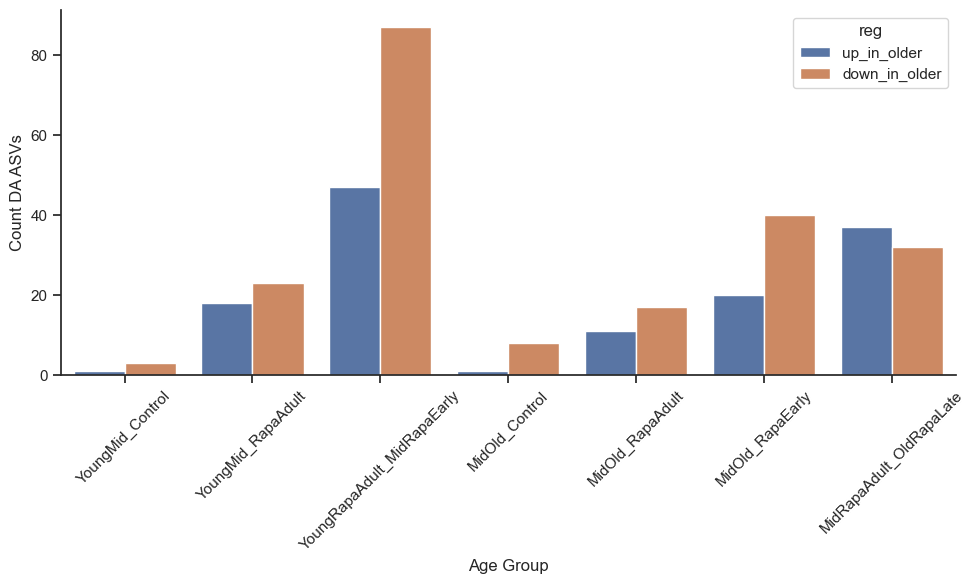

In [99]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (10, 6))
# Create the bar plot
sns.countplot(memory, x="fullname",
             order = ['YoungMid_Control', 
            "YoungMid_RapaAdult", "YoungRapaAdult_MidRapaEarly", 'MidOld_Control',
            'MidOld_RapaAdult', "MidOld_RapaEarly", "MidRapaAdult_OldRapaLate"], hue = "reg")

plt.xlabel("Age Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/MALE_memory_barplot.pdf")
plt.savefig(f"{path}/MALE_memory_barplot.png")

## Plot expression of these bacteria

In [100]:
norm_otu = pd.read_csv("../analysis/norm-CLEAN_ASVs_counts_merged_20240530.tsv", sep = "\t")
norm_otu.set_index('Sample_ID', inplace = True)
metadata = pd.read_csv("../metadata_rapaInter.csv")

# Sort metadata according to columnames to help understand groups
sorter = list(norm_otu.columns[1:])
metadata.Sample_ID = metadata.Sample_ID.astype("category")
metadata.Sample_ID = metadata.Sample_ID.cat.set_categories(sorter)
metadata = metadata.sort_values(["Sample_ID"])
metadata.set_index("Sample_ID", inplace = True)

# Transpose df and merge with metadata
expr = pd.merge(norm_otu.T, metadata, left_index = True, right_index = True)

In [101]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [102]:
expr = expr[expr["Sex"] == "m"]

In [103]:
ots = {}

for e in list(set(["ASV_121", "ASV_252", "ASV_73", "ASV_48", "ASV_175", "ASV_248", "ASV_252", "ASV_73", 
                   "ASV_11", "ASV_31", "ASV_175", "ASV_248", "ASV_113", "ASV_126", "ASV_252", "ASV_378", 
                   "ASV_73", "ASV_175", 'ASV_248'])):
    ots[list(mer[mer["OTU"] == e]["Genus"].unique())[-1]] = e
    print(e)
    display(mer[mer["OTU"] == e].loc[:, ["log2FoldChange", "padj", "Family", "Genus"]])

ASV_113


,log2FoldChange,padj,Family,Genus
35,4.253512,1.728498e-09,Desulfovibrionaceae,Bilophila
141,-1.681303,3.936879e-02,Desulfovibrionaceae,Bilophila
256,1.012808,3.401541e-02,Desulfovibrionaceae,Bilophila
351,-1.858596,1.564275e-04,Desulfovibrionaceae,Bilophila
460,2.143942,2.050815e-04,Desulfovibrionaceae,Bilophila
662,-2.798298,3.834811e-05,Desulfovibrionaceae,Bilophila
1032,1.827019,2.022969e-03,Desulfovibrionaceae,Bilophila
1314,2.009091,3.912415e-02,Desulfovibrionaceae,Bilophila
1861,-2.267453,1.772888e-05,Desulfovibrionaceae,Bilophila
2286,2.788358,1.843942e-06,Desulfovibrionaceae,Bilophila


ASV_126


,log2FoldChange,padj,Family,Genus
76,-5.569361,3.738706e-04,Erysipelotrichaceae,Faecalibaculum
464,6.613731,1.210094e-05,Erysipelotrichaceae,Faecalibaculum
573,-8.549909,1.508482e-02,Erysipelotrichaceae,Faecalibaculum
621,-6.201473,1.812361e-03,Erysipelotrichaceae,Faecalibaculum
761,-4.273948,2.345768e-02,Erysipelotrichaceae,Faecalibaculum
1137,5.115213,1.129848e-02,Erysipelotrichaceae,Faecalibaculum
1316,6.681314,4.041120e-05,Erysipelotrichaceae,Faecalibaculum
1406,-4.759433,6.259535e-03,Erysipelotrichaceae,Faecalibaculum
1484,-8.566400,3.366512e-08,Erysipelotrichaceae,Faecalibaculum
1601,-8.548738,1.650519e-02,Erysipelotrichaceae,Faecalibaculum


ASV_252


,log2FoldChange,padj,Family,Genus
57,5.142085,1.856283e-02,Peptostreptococcaceae,Romboutsia
176,-6.155119,1.021496e-07,Peptostreptococcaceae,Romboutsia
384,-6.340526,1.437628e-09,Peptostreptococcaceae,Romboutsia
590,-5.370192,8.199546e-03,Peptostreptococcaceae,Romboutsia
697,3.936762,4.102561e-05,Peptostreptococcaceae,Romboutsia
1334,8.609332,1.798717e-18,Peptostreptococcaceae,Romboutsia
1613,-5.618874,1.879971e-03,Peptostreptococcaceae,Romboutsia
2301,-2.430062,3.865452e-02,Peptostreptococcaceae,Romboutsia
2406,-4.701912,8.906210e-03,Peptostreptococcaceae,Romboutsia
2500,4.950672,1.539660e-03,Peptostreptococcaceae,Romboutsia


ASV_378


,log2FoldChange,padj,Family,Genus
100,3.486312,0.005786,Peptostreptococcaceae,Romboutsia
204,-6.132132,0.000037,Peptostreptococcaceae,Romboutsia
398,-5.951085,0.000001,Peptostreptococcaceae,Romboutsia
604,-4.610795,0.035176,Peptostreptococcaceae,Romboutsia
1339,6.676734,0.000006,Peptostreptococcaceae,Romboutsia
1619,-5.066251,0.012172,Peptostreptococcaceae,Romboutsia
2512,5.721499,0.001584,Peptostreptococcaceae,Romboutsia
2934,-6.055415,0.031968,Peptostreptococcaceae,Romboutsia
3448,5.377770,0.004078,Peptostreptococcaceae,Romboutsia


ASV_73


,log2FoldChange,padj,Family,Genus
92,5.907659,4.953876e-04,Carnobacteriaceae,Atopostipes
129,4.841422,1.068812e-02,Carnobacteriaceae,Atopostipes
338,4.638018,1.893156e-02,Carnobacteriaceae,Atopostipes
448,5.479871,1.224744e-03,Carnobacteriaceae,Atopostipes
752,10.134411,1.155062e-06,Carnobacteriaceae,Atopostipes
1019,13.118960,1.940017e-13,Carnobacteriaceae,Atopostipes
1083,5.920587,2.248132e-02,Carnobacteriaceae,Atopostipes
1194,10.791444,3.223729e-07,Carnobacteriaceae,Atopostipes
1307,9.765799,1.805445e-06,Carnobacteriaceae,Atopostipes
1535,-14.065501,6.184226e-14,Carnobacteriaceae,Atopostipes


ASV_11


,log2FoldChange,padj,Family,Genus
228,1.344961,0.035426,Lachnospiraceae,A2
427,2.248409,0.003535,Lachnospiraceae,A2
1633,-2.242616,0.017230,Lachnospiraceae,A2
1819,2.398848,0.042014,Lachnospiraceae,A2
2170,2.414308,0.003608,Lachnospiraceae,A2
3396,2.791442,0.008699,Lachnospiraceae,A2


ASV_31


,log2FoldChange,padj,Family,Genus
9,2.533797,3.310212e-02,Lachnospiraceae,Lachnospiraceae_NK4A136_group
115,-2.182024,3.795769e-02,Lachnospiraceae,Lachnospiraceae_NK4A136_group
237,1.654163,1.137231e-02,Lachnospiraceae,Lachnospiraceae_NK4A136_group
435,2.102770,2.058538e-03,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1008,-2.696953,1.241636e-04,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1116,1.966561,2.121619e-02,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1180,-2.249226,1.361977e-04,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1591,3.574670,8.129498e-05,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1637,-4.112060,2.656530e-06,Lachnospiraceae,Lachnospiraceae_NK4A136_group
2176,4.313227,5.779585e-07,Lachnospiraceae,Lachnospiraceae_NK4A136_group


ASV_48


,log2FoldChange,padj,Family,Genus
19,1.200768,0.007964,Lachnospiraceae,Lachnospiraceae_NK4A136_group
90,1.301795,0.013161,Lachnospiraceae,Lachnospiraceae_NK4A136_group
439,0.878687,0.039275,Lachnospiraceae,Lachnospiraceae_NK4A136_group
745,0.815143,0.047126,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1184,1.040496,0.010700,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1303,1.580724,0.013919,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1768,-1.780306,0.019815,Lachnospiraceae,Lachnospiraceae_NK4A136_group
1824,1.360309,0.027445,Lachnospiraceae,Lachnospiraceae_NK4A136_group
2448,1.406258,0.000130,Lachnospiraceae,Lachnospiraceae_NK4A136_group
2976,-1.947873,0.000097,Lachnospiraceae,Lachnospiraceae_NK4A136_group


ASV_121


,log2FoldChange,padj,Family,Genus
142,5.427753,1.352826e-03,Lactobacillaceae,Lactobacillus
463,-1.854828,4.926415e-02,Lactobacillaceae,Lactobacillus
666,3.483200,5.953208e-03,Lactobacillaceae,Lactobacillus
1547,2.600486,8.333465e-03,Lactobacillaceae,Lactobacillus
1669,3.373203,1.332747e-02,Lactobacillaceae,Lactobacillus
2112,-7.516694,4.092697e-05,Lactobacillaceae,Lactobacillus
2188,-7.161306,2.254186e-10,Lactobacillaceae,Lactobacillus
2381,-2.618937,1.570672e-02,Lactobacillaceae,Lactobacillus
2750,3.622065,6.822327e-04,Lactobacillaceae,Lactobacillus
2865,-7.686165,1.608063e-28,Lactobacillaceae,Lactobacillus


ASV_175


,log2FoldChange,padj,Family,Genus
97,4.848267,3.463425e-03,Carnobacteriaceae,Atopostipes
155,4.259482,2.478691e-02,Carnobacteriaceae,Atopostipes
475,5.645008,9.808200e-08,Carnobacteriaceae,Atopostipes
680,3.087054,3.367077e-02,Carnobacteriaceae,Atopostipes
771,8.965336,1.070115e-05,Carnobacteriaceae,Atopostipes
833,4.007177,5.472844e-04,Carnobacteriaceae,Atopostipes
893,5.372208,8.276547e-03,Carnobacteriaceae,Atopostipes
985,5.380353,1.306553e-03,Carnobacteriaceae,Atopostipes
1040,27.441233,1.613833e-54,Carnobacteriaceae,Atopostipes
1225,10.720748,1.288500e-06,Carnobacteriaceae,Atopostipes


ASV_248


,log2FoldChange,padj,Family,Genus
98,6.041706,4.140619e-10,Staphylococcaceae,Jeotgalicoccus
173,3.279038,2.036686e-03,Staphylococcaceae,Jeotgalicoccus
382,3.317688,9.001808e-03,Staphylococcaceae,Jeotgalicoccus
489,5.407770,1.632068e-06,Staphylococcaceae,Jeotgalicoccus
785,4.959714,1.015885e-05,Staphylococcaceae,Jeotgalicoccus
1052,10.273993,1.264705e-23,Staphylococcaceae,Jeotgalicoccus
1097,4.270428,2.953943e-02,Staphylococcaceae,Jeotgalicoccus
1151,4.639976,1.469567e-02,Staphylococcaceae,Jeotgalicoccus
1240,6.631277,4.479692e-08,Staphylococcaceae,Jeotgalicoccus
1333,3.110062,1.763597e-02,Staphylococcaceae,Jeotgalicoccus


In [106]:
ots = {'Bilophila': ['ASV_113'],
 'Faecalibaculum': ['ASV_126'],
       "Romboutsia2": ["ASV_252"],
 'Romboutsia': ['ASV_378'],
       'Atopostipes2': ['ASV_73'],
 'Atopostipes': ['ASV_175'],
 'Lachnospiraceae_A2': ['ASV_11'],
       'Lachnospiraceae_NK4A136_group2': ['ASV_31'],
 'Lachnospiraceae_NK4A136_group': ['ASV_48'],
 'Lactobacillus': ['ASV_121'],
 'Jeotgalicoccus': ['ASV_248']}

In [79]:
ots = {"Muribaculaceae1": ['ASV_5'],
       "Muribaculaceae2": ['ASV_34'],
       "Muribaculaceae3":["ASV_223"],
       "Muribaculaceae4":["ASV_4"],
       "Muribaculaceae5":["ASV_28"],
       "Muribaculaceae6":["ASV_26"],
 'Prevotellaceae_UCG-001': ['ASV_35'],
 'Lachnospiraceae_NK4A136_group': ['ASV_88'],
       "Muribaculaceae7":["ASV_58"],
 'Staphylococcus': ['ASV_93'],
      "Muribaculaceae8":["ASV_148"],
      "Muribaculaceae9":["ASV_49"]}

In [54]:
ots = {"Muribaculaceae": ['ASV_34'],
 'Staphylococcus': ['ASV_93'],
       "Lactobacillus2":["ASV_202"],
       "Lachnospiraceae_NK4A136_group2":["ASV_10"],
       "Lactobacillus3":["ASV_85"],
 'Lactobacillus': ['ASV_16']}

In [49]:
ots = {"Clostridiales_vadinBB60_group": ['ASV_390'], 'Jeotgalicoccus': ['ASV_248']}

In [107]:
palettesex = {'Control': '#000000',
 'Rapa Adult': '#c34e0d',
 'Rapa Early': '#5a9f68',
 'Rapa Late': '#4170b0'}

def plot_expression(bacteria):

    df = expr.loc[:, ots[bacteria] + ["Sex", "Treatment", "Age"]]

    ax = sns.boxplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment", palette = palettesex, 
               order = ["Young", "Mid", "Old"], showfliers = False)

    ax = sns.swarmplot(df, x="Age", y = ots[bacteria][0], hue = "Treatment",
                          dodge = True, color = ".25", ax = ax, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel(f"Z-score abundance\n({bacteria} {ots[bacteria][0]})")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/MALE_mem2_{bacteria}_expression.pdf")
    plt.savefig(f"{path}/MALE_mem2_{bacteria}_expression.png")
    plt.show()

Bilophila


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


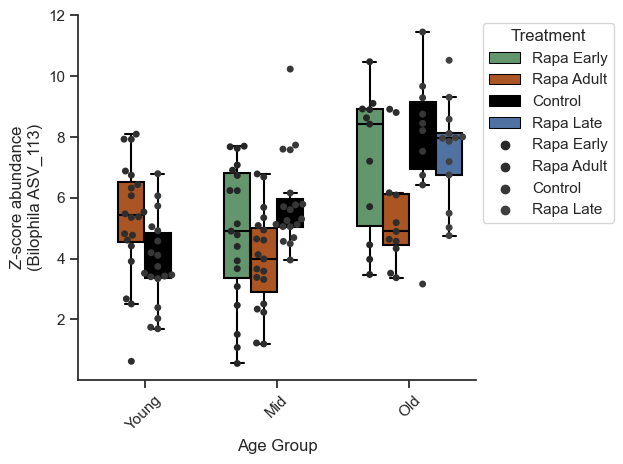

Faecalibaculum


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


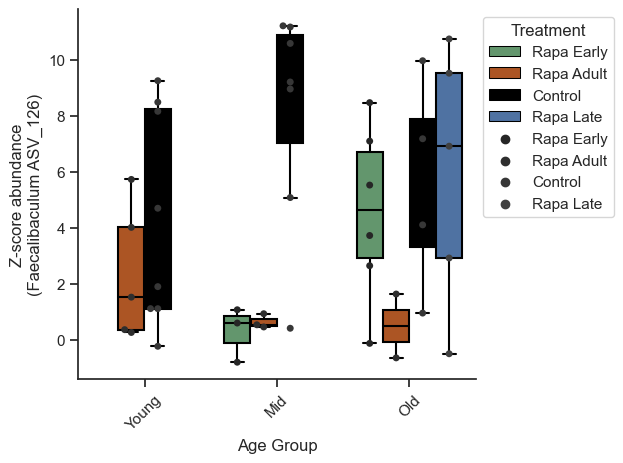

Romboutsia2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


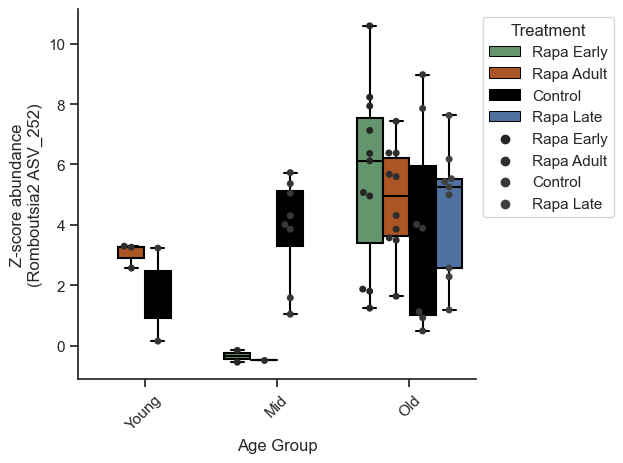

Romboutsia


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


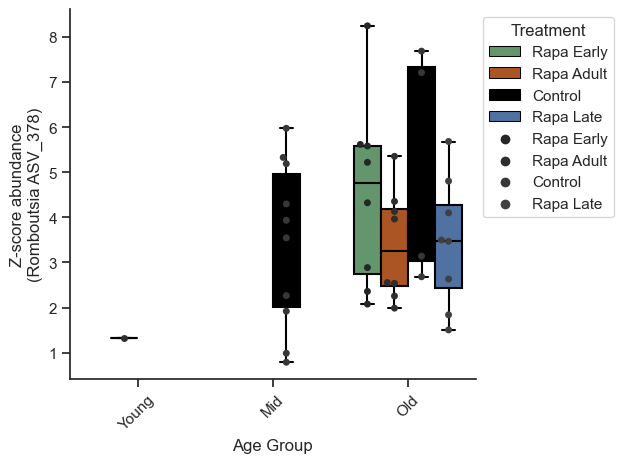

Atopostipes2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


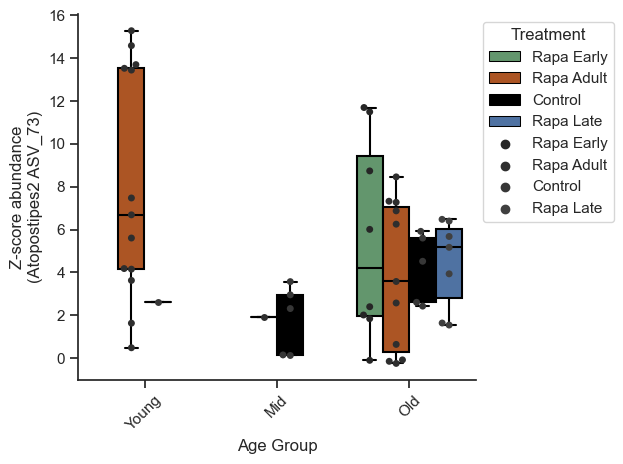

Atopostipes


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


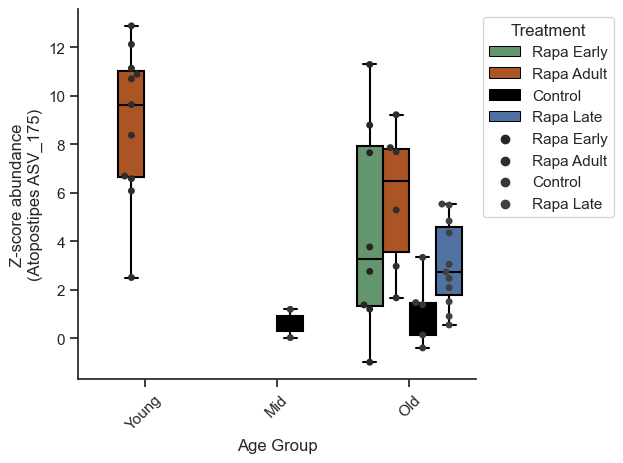

Lachnospiraceae_A2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


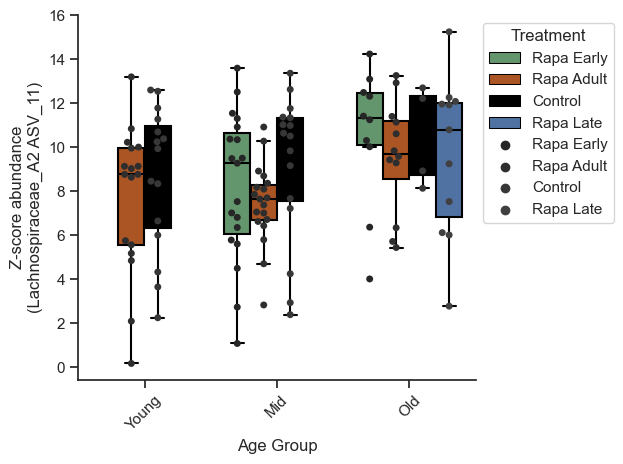

Lachnospiraceae_NK4A136_group2


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


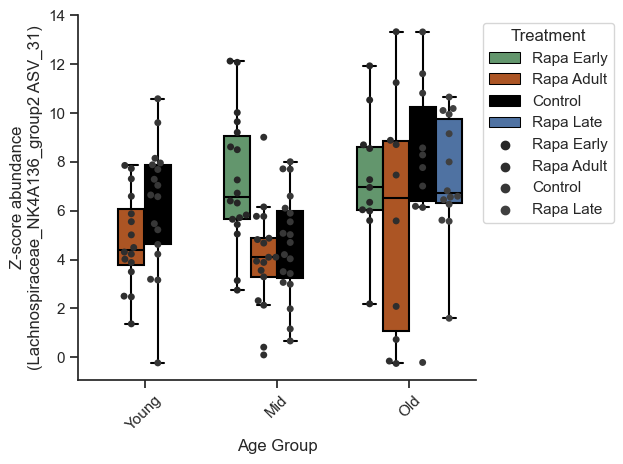

Lachnospiraceae_NK4A136_group


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


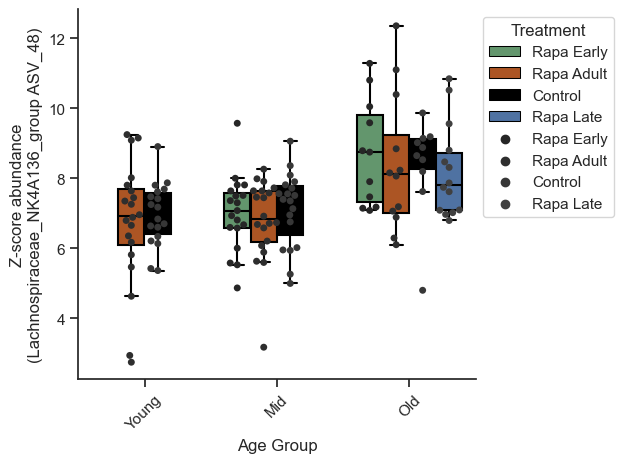

Lactobacillus


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


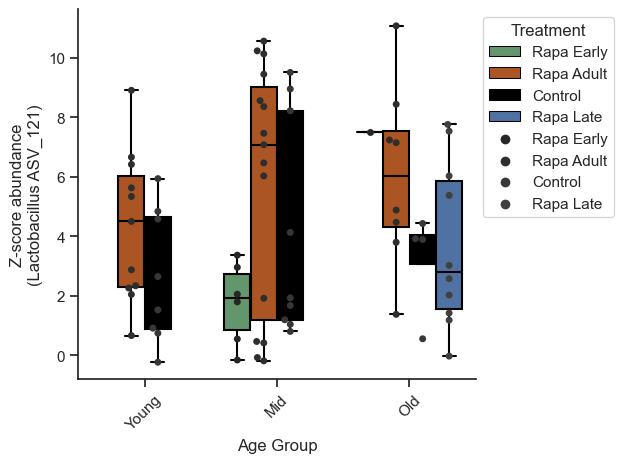

Jeotgalicoccus


/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


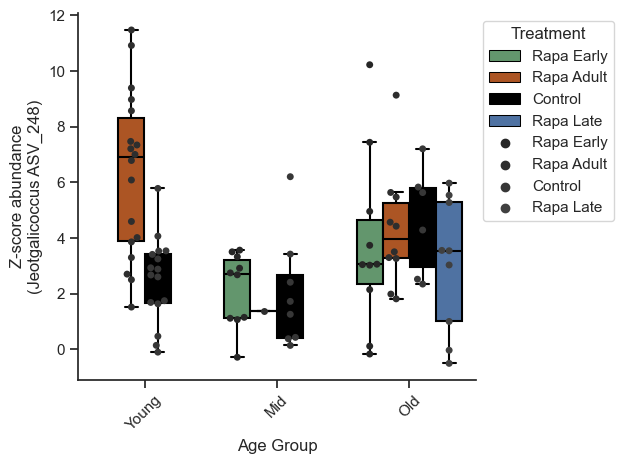

In [108]:
for e in list(ots.keys()):
    print(e)
    plot_expression(e)